# Inference of parameters with latent variables (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the epidemiological parameters as well as control parameters from the $I_\mathrm{s}$ trajectory. 

For the pre-intervention period, we infer the following parameters as well as initial conditions: 
* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

For the post-intervention period, we infer the following control parameters: 
* $a_\mathrm{W}$ fraction of work contact, 
* $a_\mathrm{S}$ fraction of social contact, 
* $a_\mathrm{O}$ fraction of other contacts 

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1) Generate a trajectory
We generate a test trajectory on a population with four ages groups using UK contact matrix

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]

Ni = (Ni/5e2).astype('int') # Scale the numbers to avoid numerical problems
N = np.sum(Ni)

In [4]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

T_intervention = 20 
times= [T_intervention] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.5, 0.5, 0.4

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [5]:
beta  = 0.04      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.2              # asymptomatic fraction
fsa   = 0.8               # suppresion of contact by symptomatics


# initial conditions    
Is0 = np.ones(M)*10
Ia0 = np.ones((M))*10
R0  = np.zeros((M))
S0  = Ni - (Ia0 + Is0 + R0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SIR(parameters, M, Ni)

# start simulation
Tf=100;  Nf=Tf+1 
data=model.simulate(S0, Ia0, Is0, C, Tf, Nf)
np.save('cal_lat_SIR_traj.npy', data['X'])

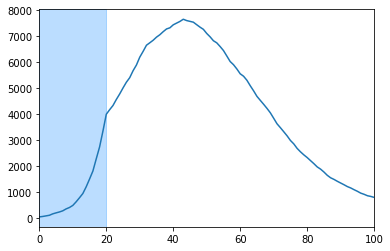

In [6]:
# plot the number of infected people 
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.show() 

## 2) Infer the parameters and initial conditions for the pre-intervention trajectory

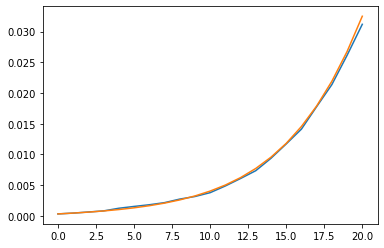

In [7]:
Tf_initial = T_intervention # truncate to only getting the pre-intervention trajectory 
Nf_initial = Tf_initial+1

x = (np.load('cal_lat_SIR_traj.npy')).astype('float')
x = (x/N)[:Nf_initial]
steps = 101 # number internal integration steps taken

fltr=np.repeat(np.array([False, False, True]), M)
obs=x[:, fltr] 


# First, check the deterministic simulation against stochstic simulations with the same parameters and initial conditons 
# They are likely to be different due to the inherent stochasticity of the model 
contactMatrix = generator.constant_contactMatrix()
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)
xm = estimator.integrate(x[0], 0, Tf_initial, Nf_initial, det_model, contactMatrix)
t = np.linspace(0, Tf_initial, Nf_initial)
plt.plot(t, np.sum(x[:,2*M:3*M], axis=1))
plt.plot(t, np.sum(xm[:,2*M:3*M], axis=1))
plt.show()

In [8]:
# Initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# Compute -log_p for the original (correct) parameters 
# This gives an estimate of the final -logp we expect from the optimisation scheme 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x[0], obs[1:], fltr, Tf_initial, Nf_initial, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-661.4015773449049
0.2729480266571045


In [9]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3 

alpha_g = 0.15
alpha_std = 0.1
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.1
beta_std = 0.1 
beta_bounds = (eps, 1)

gIa_g = 0.13
gIa_std = 0.05 # small stds for rate of recovery (can obtain from clinical data)
gIa_bounds = (0.1, 0.3)

gIs_g = 0.13
gIs_std = 0.05 # small stds for rate of recovery (can obtain from clinical data)
gIs_bounds = (0.1, 0.3) 

# not inferred 
fsa_g = 0.8

Ia0_g = (Ia0-3)/N
Ia_std = Ia0_g*2
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)


Is0_g = (Is0-3)/N 
Is_std = Is0_g*0.5 
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = (S0+10)/N
S_std = Ia_std*2
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)

# Optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# Set up bounds, guess and stds for the rest of the params 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, *S_std, *Ia_std, *Is_std])

# Run the optimiser 
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_initial, Nf_initial, 
                                    generator.constant_CM, bounds, 
                                    global_max_iter=15, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 16 (seed=942042, Thu May  7 15:30:06 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.164807578301178e+02 1.0e+00 9.49e-01  7e-04  9e-02 0:02.7
    2     32 -3.683132754424199e+02 1.1e+00 8.88e-01  6e-04  9e-02 0:05.0
    3     48 -6.674946091664970e+02 1.2e+00 8.71e-01  6e-04  9e-02 0:07.1
    5     80 -6.802621633081314e+02 1.3e+00 8.21e-01  6e-04  8e-02 0:11.5
    7    112 -6.726851630844437e+02 1.3e+00 8.53e-01  6e-04  9e-02 0:16.5
   10    160 -4.936248321482650e+02 1.5e+00 8.34e-01  6e-04  8e-02 0:22.4
   14    224 -6.392131363128939e+02 1.6e+00 7.98e-01  5e-04  8e-02 0:28.8
Optimal value (global minimisation):  -704.6360123032844
Starting local minimisation...
Optimal value (local minimisation):  -721.6212982913344
50.46560597419739


In [10]:
# save the parameters 
np.save('SIR_cal_lat_param.npy', params)

In [11]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

params = np.load('SIR_cal_lat_param.npy')
best_estimates = estimator.make_params_dict(params)
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, Ia0, Is0)
print('\n Inferred initial conditons: ') 
print((params[4:]*N).astype('int'))

True parameters
{'alpha': 0.2, 'beta': 0.04, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8}

 Best estimates
{'alpha': 0.33808790397911714, 'beta': 0.03705298503973277, 'gIa': 0.1436147968126738, 'gIs': 0.11979717550096089, 'fsa': 0.8}

 True initial conditions: 
[31248.886 35648.366 35506.088 25739.864] [10. 10. 10. 10.] [10. 10. 10. 10.]

 Inferred initial conditons: 
[31271 35690 35472 25720    10    19    11    11     7    10    13    10]


### Check the inferred trajectory against the true trajectory for pre-intervention

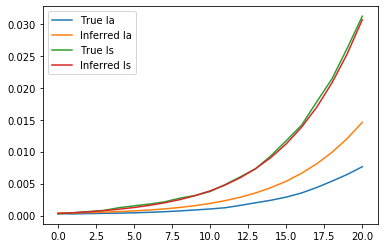

In [18]:
x = np.load('cal_lat_SIR_traj.npy')/N
x0 = params[4:]

# set params for estimate
estimator.set_params(best_estimates)

# make det_model and contactMatrix 
det_model = pyross.deterministic.SIR(best_estimates, M, fi)
contactMatrix = generator.constant_contactMatrix()

# generate the deterministic trajectory 
x_det = estimator.integrate(x0, 0, Tf_initial, Nf_initial, det_model, contactMatrix)
plt.plot(np.sum(x[:Nf_initial,M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:Nf_initial,2*M:3*M], axis=1), label='True Is')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.legend()
plt.show()

Quite good at inferring Is (which it can see), not so good at inferring Ia (which it cannot see)

## 3) Infer the control parameters 
We infer the control parameters, assuming that the previously inferred initial conditions and epidemiological parameters 

In [21]:
# Test the -logp for the correct control parameters 

# get the trajectory 
x = np.load('cal_lat_SIR_traj.npy')/N
x = x[Nf_initial:]
obs = x[:, fltr]
Nf_control = x.shape[0] 
Tf_control = Nf_control-1


# Set the initial condition for post-intervention 
x0_control = np.array(x_det[-1])

# get the contact matrix for post-intervention 
times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# calculate minus_log_p for the correct control parameters  
logp = estimator.minus_logp_red(best_estimates, x0, obs[1:], fltr, Tf_control, Nf_control, contactMatrix)
print(logp) 

-2371.289635765629


In [22]:
# set up initial guess and bounds 
aW_g = 0.5 
aW_std = 0.1
aW_bounds = [0.2, 0.8]

aS_g = 0.55
aS_std = 0.1
aS_bounds = [0.2, 0.8]

aO_g = 0.45
aO_std = 0.1 
aO_bounds = [0.2, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
stds = np.array([aW_std, aS_std, aO_std])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])

ftol = 1e-4

start_time = time.time() 
estimator.set_params(best_estimates) 
control_params = estimator.latent_infer_control(guess, stds, x0_control, obs, fltr, Tf_control, Nf_control, 
                                              generator, bounds,
                                              global_max_iter=5, global_ftol_factor=1e4, 
                                                verbose=True, 
                                                ftol=ftol)
end_time = time.time()
print(control_params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 3 (seed=1002634, Thu May  7 15:43:55 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -2.383704833363999e+03 1.0e+00 1.16e+00  1e-01  1e-01 0:11.1
    2     32 -2.383405342412235e+03 1.4e+00 1.09e+00  9e-02  1e-01 0:21.0
    3     48 -2.394608226755422e+03 1.3e+00 1.06e+00  8e-02  1e-01 0:30.4
    4     64 -2.391854607221021e+03 1.7e+00 8.77e-01  6e-02  9e-02 0:39.7
    5     80 -2.393270715130616e+03 1.9e+00 7.19e-01  4e-02  6e-02 0:49.0
Optimal value (global minimisation):  -2394.6082267554216
Starting local minimisation...
Optimal value (local minimisation):  -2396.56262688975
[0.45384665 0.4419038  0.37490707]
67.52050399780273


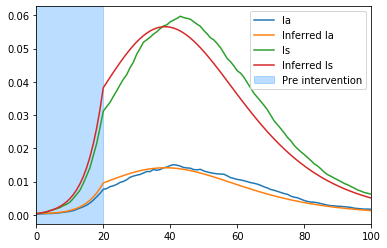

In [24]:
times = [T_intervention]
interventions = [[1.0,1.0,1.0],      # before first time
                 control_params,       # after first time
                ]         

# compare the true trajectory with the 
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)
det_model = pyross.deterministic.SIR(parameters, M, fi)
x0 = params[len(parameters)-1:]
x_det_control = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('cal_lat_SIR_traj.npy')/N
plt.plot(np.sum(x[:,M:2*M], axis=1), label='Ia')
plt.plot(np.sum(x_det_control[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:,2*M:3*M], axis=1), label='Is')
plt.plot(np.sum(x_det_control[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()